# HWRS 528 IMP05
## Uncertainty Analysis
### 1. Import Python packages

In [281]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import LRC_subprograms as lrc

### 2. Load data, choose time period, and specify model parameters

In [35]:
#==== Load Leaf River Catchment Data as a DataFrame ===============================
LRData = pd.read_csv('../LeafRiverDaily.csv')

#==== Get a number of datapoints ==================================================
Ndata = LRData.shape[0]
Nvars = LRData.shape[1]

#==== Choose a simulation time period and set up time vector ======================
Period_Start = 0; Period_End = 365*3                # select time period to work with
Time = np.arange(0, Period_End, 1)
NTime = len(Time)

#==== Set number of initial time steps to use as spin-up ==========================
# Metrics are not computed on this period
SpinUp = 90                                         # select 90-day spin-up period

#==== Get data for the desired period =============================================
PPobs = LRData.PP[Time].to_numpy()                  # Convert from DataFrame to numpy
PEobs = LRData.PE[Time].to_numpy()                  # arrays to avoid indexing issues
QQobs = LRData.QQ[Time].to_numpy()

#==== Determine max values for each variable ======================================
PPobs_max = np.max(PPobs)
PEobs_max = np.max(PEobs)
QQobs_max = np.max(QQobs)

#==== Specify model parameters ====================================================
NRes = 2; ResIdex = np.arange(0, NRes, 1)

In [ ]:
def fix_hist_step_vertical_line_at_end(ax):
    axpolygons = [poly for poly in ax.get_children() if isinstance(poly, mpl.patches.Polygon)]
    for poly in axpolygons:
        poly.set_xy(poly.get_xy()[:-1])

### 3. Monte Carlo parameter value generations

##### 3.1 Create Monte Carlo Generator subprograms

In [36]:
#==== Monte Carlo Parameter Value Generator (for one parameter) =====================================
def ParGenerator(Bounds, NValues, seed):
    
    #==== Define upper and lower bounds from input ==================================================
    LowerBound = Bounds[0]; UpperBound = Bounds[1]

    #==== Initialize list and MCA components ========================================================
    ParValues = []              # List to hold generated parameter values
    random.seed(seed)           # Seed random number generator
    currentRoll = 1             # counter for Monte Carlo generator

    #==== Run Monte Carlo and generate parameter values =============================================
    while currentRoll <= NValues:
        r = random.random()                                     # Random number between [0,1]
        ParValue = LowerBound + (UpperBound-LowerBound) * r     # generate parameter value between bounds
        ParValues.append(ParValue)                              # add parameter value to list

        currentRoll += 1

    return ParValues

#==== Compile list of Monte Carlo-generated parameter value lists ====================================
def ParList(ParBounds, NValues):
    NPars  = len(ParBounds)                                     # Number of parameters to generate values
    ParIdx = np.arange(0, NPars, 1)
    ParValueList = []                                           # List to hold lists of parameter values

    for i in ParIdx:
        seed = random.randint(0, 1000)                          # Random seed for each ParGenerator iteration
        Bounds = ParBounds[i]                                   # Set bounds for each parameter
        ParValues = ParGenerator(Bounds, NValues, seed)         # Run ParGenerator_fun to create list of parameter values
        ParValueList.append(ParValues)                          # Compile list of parameter value lists

    return ParValueList

#==== Compile list of parameter sets ================================================================
def ParSets(ParBounds, NValues):
    ParValueList = ParList(ParBounds, NValues)                  # Run ParList_fun to generate list of parameter values\
                                                                # for each parameter.
    Par1 = ParValueList[0]; Par2 = ParValueList[1]; Par3 = ParValueList[2]  # Separate ParValueList into one list for\
    Par4 = ParValueList[3]; Par5 = ParValueList[4]; Par6 = ParValueList[5]  # each parameter (six total lists).

    ParSetList = []                                             # List to hold MC-generated parameter sets
    ParSetIdx = np.arange(0, NValues, 1)

    for i in ParSetIdx:
        ParSet = [Par1[i], Par2[i], Par3[i],                    # Create parameter set by pulling nth element from\
                  Par4[i], Par5[i], Par6[i]]                    # parameter value lists
        ParSetList.append(ParSet)                               # Compile list of parameter sets
    
    return ParSetList

##### 3.2 Create Ensemble running program

In [190]:
#==== Run an ensemble of models and record outputs/performance metrics ============================================ 
def EnsembleRunner(ParSetList, PPobs, PEobs, QQobs, NRes):
    NParSets   = len(ParSetList); ParSetsIdx = np.arange(0, NParSets, 1)

    QQsimList = []; MSEList   = []; NSEList  = []                           # Lists to capture outputs and perf metrics\
    KGEssList = []; alphaList = []; betaList = []                           # for each model run within the ensemble
    rhoList   = []

    for i in ParSetsIdx:                                                    # Run the ith model in the ensemble
        Pars = ParSetList[i]                                                # Select the ith parameter set from list of models
        [QQsim, AEsim, MSE,NSE,NSEL,KGEss,KGE,alpha,beta,rho] = lrc.MainCatchModel(Pars, PPobs, PEobs, QQobs, NRes)

        QQsimList.append(QQsim); MSEList.append(MSE); NSEList.append(NSE)           # Compile metrics and outputs
        KGEssList.append(KGEss); alphaList.append(alpha); betaList.append(beta)
        rhoList.append(rho)

    return [QQsimList, MSEList, NSEList, KGEssList, alphaList, betaList, rhoList]

### 4. Build MonteCarlo/Fixed parameter ensembles
##### 4.1 Build Monte Carlo ensembles (all varied)

In [257]:
#==== Set number of iterations ==========================================
NValues = 1000

#==== Set paramter bounds ===============================================
            # Theta_C1  Theta_P1  Theta_K12  Theta_K13   Theta_K2Q    Theta_K3Q
ParBounds = [[10,300], [0.5,1.5], [0.0,0.5], [0.0,0.9], [0.0001,0.1], [0.1,0.9]]
ParNames  = ['Theta_C1', 'Theta_P1', 'Theta_K12', 'Theta_K13', 'Theta_K2Q', 'Theta_K3Q']
#==== DSM-optimized parameter values ====================================
OptParSet = [77.1, 0.5, 0.049, 0.019, 0.0001, 0.576]

ParSetList = ParSets(ParBounds, NValues)

##### 4.2 Build fixed parameter value model ensembles (one par value held constant)

In [227]:
#==== Create parameter sets with fixed parameter value for each optimized par value =====================
NPars = len(OptParSet); OptParIdx = np.arange(0, NPars, 1)      # Create index for replacement
FixedParSetList = []                                            # List to hold sets of fixed parameter values

for i in OptParIdx:
    OptPar = OptParSet[i]
    FixedPar_i_Set = [[OptPar if j == i else x for j,x in enumerate(ParSet)] for ParSet in ParSetList]
    FixedParSetList.append(FixedPar_i_Set)

### 5. MC-generated model running and analysis
##### 5.1 Run Ensemble of NValues and compile results

In [264]:
# SHOULD BE ABLE TO BE REPLACED BY NEW FUNCTION, ENSEMBLERUNNER_fun
[QQsimList, MSEList, NSEList, KGEssList, alphaList, betaList, rhoList] = EnsembleRunner(ParSetList,PPobs, PEobs, QQobs, NRes)

##### 5.2 Run Npar of ensembles and compile results for Uncertainty Analysis

In [233]:
#==== Run NPar ensembles (each ensemble has a different parameter's value fixed) =============================
QQsimSet = []; MSESet   = []; NSESet  = []                  # Master sets to compile list of ensemble outputs \
KGEssSet = []; alphaSet = []; betaSet = []                  # and metrics
rhoSet   = []

for i in OptParIdx:                                 
    FixedParSet = FixedParSetList[i]                        # Select ith ensemble, each with a fixed value for one parameter

    [QQsimList, MSEList, NSEList, KGEssList, alphaList, betaList, rhoList] = EnsembleRunner(FixedParSet,PPobs, PEobs, QQobs, NRes)
    QQsimSet.append(QQsimList); MSESet.append(MSEList); NSESet.append(NSEList)
    KGEssSet.append(KGEssList); alphaSet.append(alphaList); betaSet.append(betaList)
    rhoSet.append(rhoList)

METRICS = [NSESet, KGEssSet, alphaSet, betaSet, rhoSet]

c:\Users\moral\OneDrive\UofA\2022-2023\23 - Spring\HWRS 528 - Systems Modeling\imp\imp05\LRC_subprograms.py:47: RuntimeWarning: invalid value encountered in double_scalars
  AE   = np.minimum(XX1a, PE*(XX1a/Theta_C1)**Theta_P1) # Actual evaporation limited by PE or water content


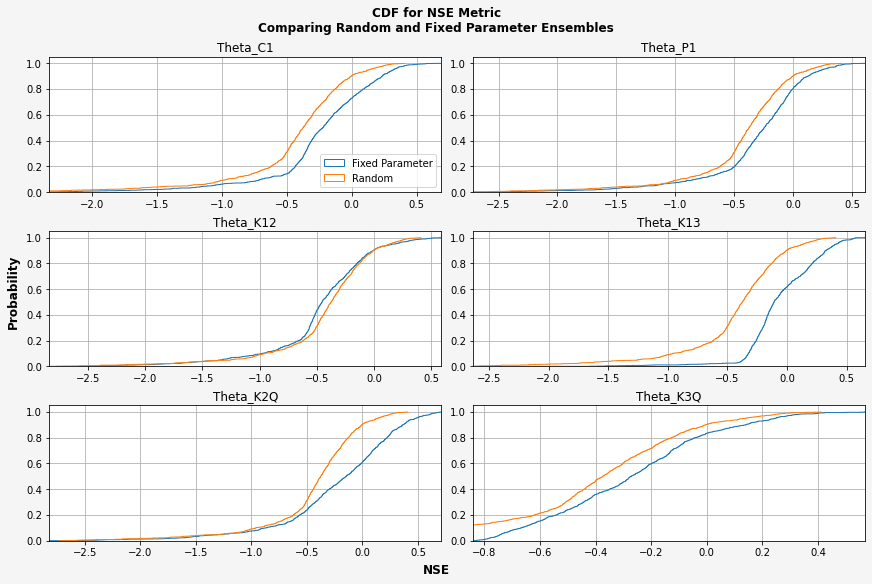

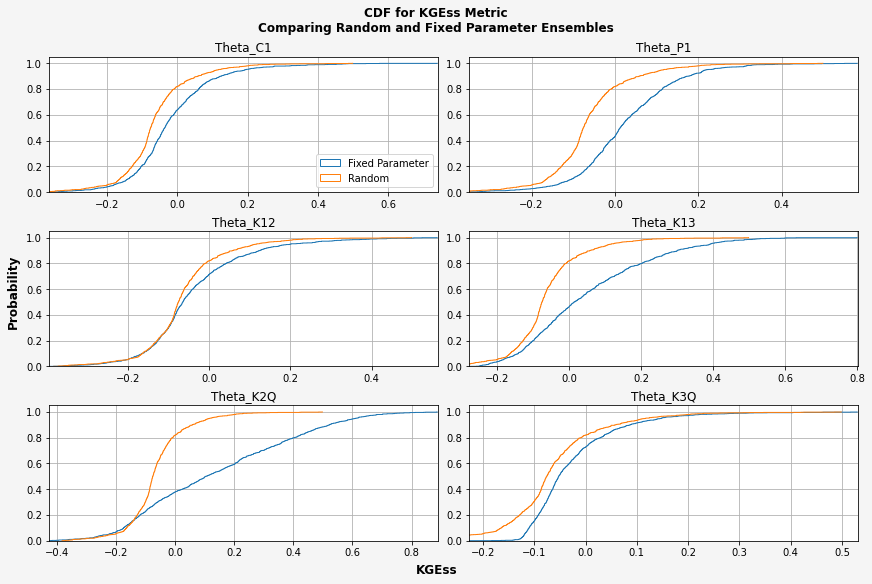

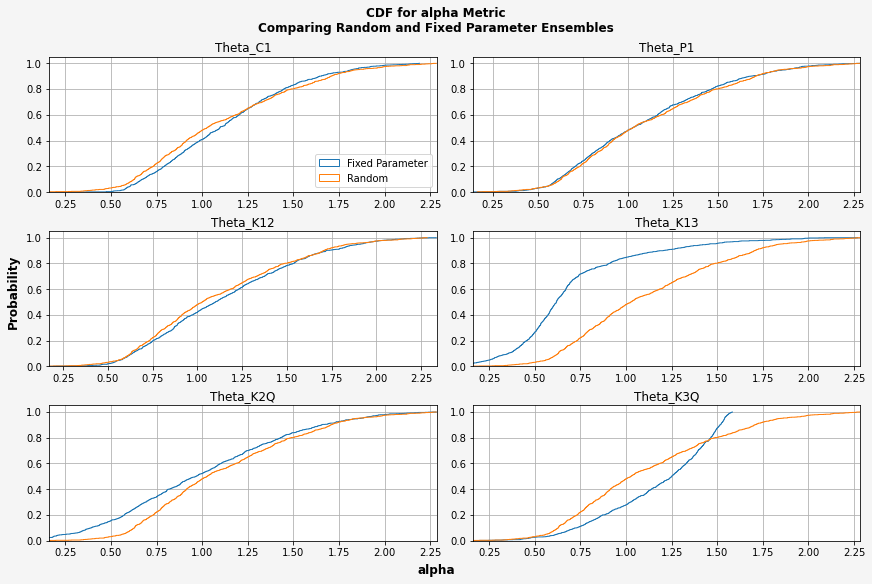

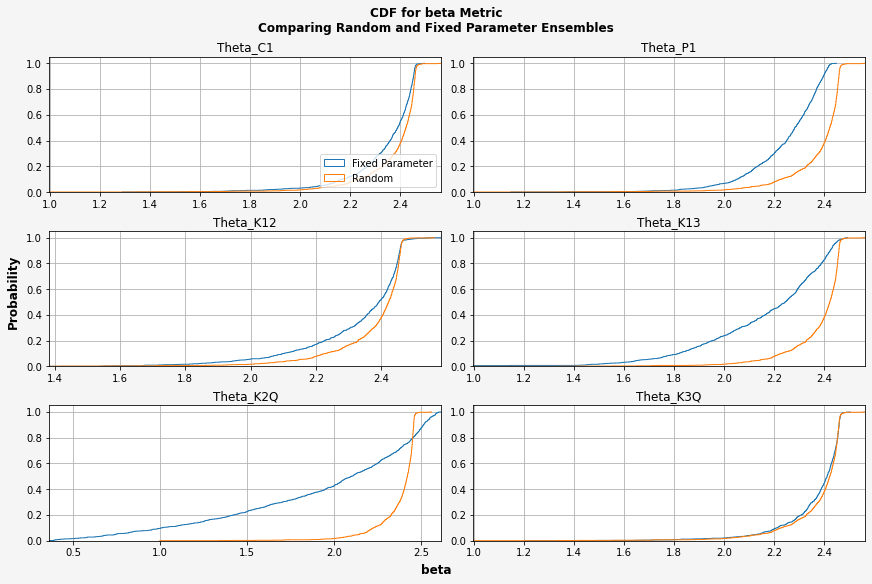

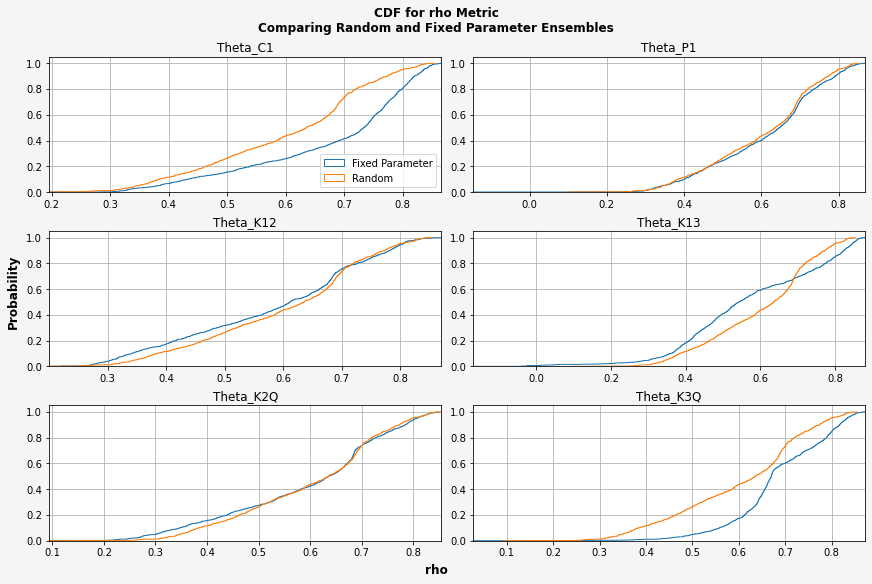

In [306]:
#==== Plot Metric CDFs for Fixed parameter and random model ensembles ================================================
METRICS_rand = [NSEList, KGEssList, alphaList, betaList, rhoList]
METRICS_fixd = [NSESet, KGEssSet, alphaSet, betaSet, rhoSet]
MetricNames = ['NSE', 'KGEss', 'alpha', 'beta', 'rho']

NMetricNames = len(MetricNames); MetricsIdx = np.arange(0, NMetricNames, 1)

for k in MetricsIdx:
    MetricSet_fixd = METRICS_fixd[k]
    MetricSet_rand = METRICS_rand[k]
    MetricName = MetricNames[k]

    fig, ax = plt.subplots(nrows=3, ncols=2, facecolor='whitesmoke', constrained_layout=True, figsize=(12,8))
    fig.supylabel('Probability', fontweight='bold')
    fig.supxlabel(MetricName, fontweight='bold')
    fig.suptitle(f'CDF for {MetricName} Metric\nComparing Random and Fixed Parameter Ensembles', fontweight='bold')

    idx=0
    for i in np.arange(0,3,1):
        for j in np.arange(0,2,1):
            ParName = ParNames[idx]
            Metric_i = np.array(MetricSet_fixd[idx])
            Metric_i = Metric_i[~np.isnan(Metric_i)]
            ax[i, j].hist(Metric_i, density=True, cumulative=True, histtype='step',bins=1000, label='Fixed Parameter')
            ax[i, j].hist(MetricSet_rand, density=True, cumulative=True, histtype='step', bins=1000, label='Random')
            if np.max(Metric_i) > np.max(MetricSet_rand):
                ax[i, j].set_xlim(np.min(Metric_i), np.max(Metric_i))
            else:
                ax[i, j].set_xlim(np.min(MetricSet_rand), np.max(MetricSet_rand))
            ax[i, j].set_title(ParName)
            ax[0, 0].legend(loc='lower right')
            ax[i, j].grid('--k')
            fix_hist_step_vertical_line_at_end(ax[i, j])
            idx+=1
    plt.show()

Variane of Theta_C1: 0.014961479796259213


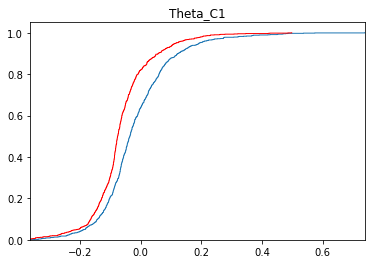

Variane of Theta_P1: 0.014509279023874038


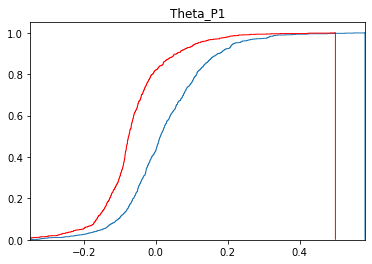

Variane of Theta_K12: 0.016872764477671148


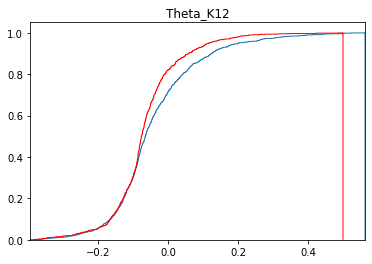

Variane of Theta_K13: 0.030967102194585035


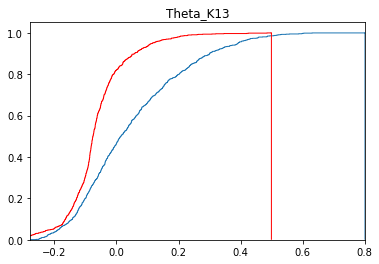

Variane of Theta_K2Q: 0.07275412094086897


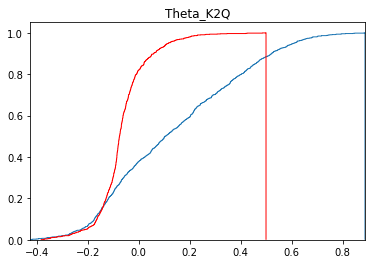

Variane of Theta_K3Q: 0.008053609940822165


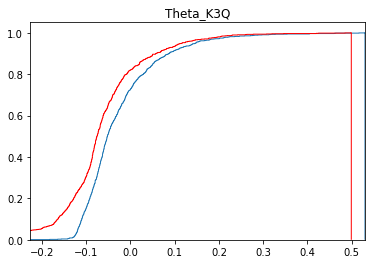

In [283]:
NMetrics = len(KGEssSet); MetricsIdx = np.arange(0, NMetrics, 1)
fig, ax = plt.subplots()

for i in MetricsIdx:
    ParName = ParNames[i]
    KGEss_i = np.array(KGEssSet[i])
    KGEss_i = KGEss_i[~np.isnan(KGEss_i)]
    KGEss_i_var = np.var(KGEss_i)
    print(f'Variane of {ParName}: {KGEss_i_var}')
    plt.hist(KGEss_i, density=True, cumulative=True, histtype='step', bins=1000)
    plt.hist(KGEssList, density=True, cumulative=True,histtype='step', bins=1000, color='r')
    plt.xlim(np.min(KGEss_i), np.max(KGEss_i))
    plt.title(ParName)
    fix_hist_step_vertical_line_at_end(ax)
    plt.show()

In [241]:
x = np.array(KGEssSet[1])
x = x[~np.isnan(x)]

In [245]:
np.var(x)

0.014509279023874038

##### 5.3 Analyze MC-generated model results

In [72]:
#==== Calculate the 0.5 and 0.95 quantiles for streamflow values from MC-generated parameter values =========
QQ_95_quantile = np.quantile(QQsimList, 0.95, axis=0, keepdims=True)[0]
QQ_05_quantile = np.quantile(QQsimList, 0.05, axis=0, keepdims=True)[0]

#==== Calculate the uncertainty of streamflow values from MC-gen parameter values ==========================
QQsimArray            = np.array(QQsimList)
QQresidual            = QQsimArray-QQobs
QQresidual_normalized = QQresidual/NTime

QQres_05_quantile = np.quantile(QQresidual_normalized, 0.95, axis=0, keepdims=True)[0].reshape(NTime,)
QQres_95_quantile = np.quantile(QQresidual_normalized, 0.05, axis=0, keepdims=True)[0].reshape(NTime,)

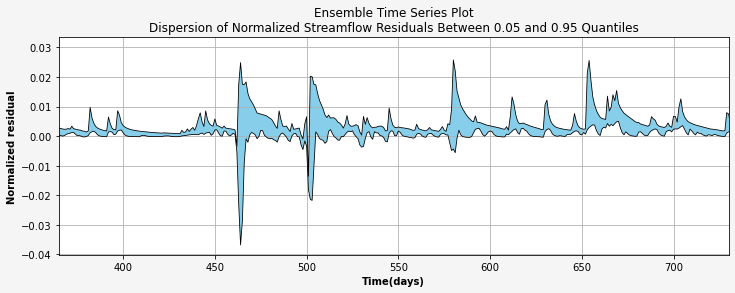

In [160]:
QQn_95 = QQres_95_quantile
QQn_05 = QQres_05_quantile

fig, ax = plt.subplots(figsize=(12,4), facecolor='whitesmoke')

ax.plot(Time, QQn_95, '-k', linewidth=0.8)
ax.plot(Time, QQn_05, '-k', linewidth=0.8)
ax.fill_between(Time, QQn_95, QQn_05, facecolor='skyblue')
ax.set_xlim(365, 730)
ax.set_xlabel('Time(days)', fontweight='bold')
ax.set_ylabel('Normalized residual', fontweight='bold')
ax.set_title('Ensemble Time Series Plot\nDispersion of Normalized Streamflow Residuals Between 0.05 and 0.95 Quantiles')
ax.grid('--k')
plt.show()

##### 4.3 Generate diagnostic plots

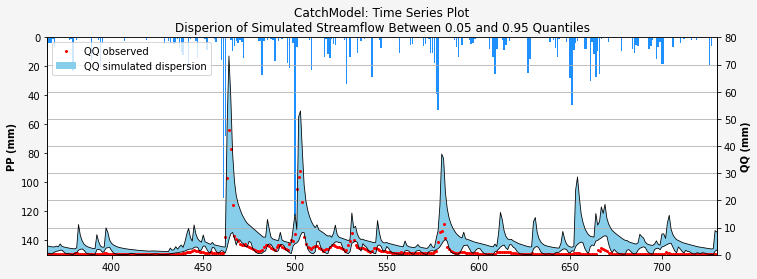

In [158]:
#==== Plot streamflow timeseries with 0.5 and 0.95 dispersion ======================================
WY1950_Start = 365; WY1950_End = 731; WY1950 = np.arange(WY1950_Start, WY1950_End, 1)

QQobs1950 = QQobs[WY1950_Start:WY1950_End]; PPobs1950 = PPobs[WY1950_Start:WY1950_End]
QQ_95 = np.transpose(QQ_95_quantile[WY1950_Start:WY1950_End])
QQ_05 = np.transpose(QQ_05_quantile[WY1950_Start:WY1950_End])

fig, ax1 = plt.subplots(squeeze=True, facecolor='whitesmoke', figsize=(12,4))

ax1.bar(WY1950, PPobs1950, label='PP observed', color='dodgerblue')
ax1.set_ylabel('PP (mm)', fontweight='bold')
ax1.set_ylim(0,150)
ax1.invert_yaxis()

ax2 = ax1.twinx()

ax2.plot(WY1950, QQobs1950, 'or', label='QQ observed', markersize=2)
ax2.plot(WY1950, QQ_95, '-k', linewidth=0.8)
ax2.plot(WY1950, QQ_05, '-k', linewidth=0.8)
ax2.fill_between(WY1950, QQ_95, QQ_05, facecolor='skyblue', label='QQ simulated dispersion')
ax2.set_ylabel('QQ (mm)', fontweight='bold')
ax2.set_xlabel('Time (days)', fontweight='bold')
ax2.set_title('CatchModel: Time Series Plot\nDisperion of Simulated Streamflow Between 0.05 and 0.95 Quantiles')
ax2.grid('--k')
ax2.set_xlim(WY1950_Start, WY1950_End-1)
ax2.set_ylim(0,80)
ax2.legend(loc=2)

plt.show()

In [131]:
QQ_95

array([ 3.2787441 ,  3.13134009,  2.96879648,  2.88933241,  2.92099638,
        3.19229243,  2.94011429,  4.00407151,  3.08346871,  2.89367369,
        2.70845732,  2.57838992,  2.43937155,  2.31907162,  2.2365574 ,
        2.2064742 ,  2.56046759, 11.12949449,  7.12555374,  5.13115084,
        3.94380745,  3.32777252,  2.95515345,  2.69020808,  2.48277641,
        2.30899268,  2.29073659,  7.41627035,  4.80056862,  3.20076169,
        2.78618746,  2.86521533,  9.9248876 ,  8.20937533,  5.37293695,
        4.24819769,  3.65824002,  3.27201874,  2.97348878,  2.72158269,
        2.57300976,  2.43063759,  2.29741478,  2.18477133,  2.06631009,
        1.99706317,  1.93186455,  1.86926008,  1.78511133,  1.69617444,
        1.62054377,  1.55600008,  1.50806216,  1.46406604,  1.41311119,
        1.35614008,  1.32342776,  1.43642135,  1.40536223,  1.3962666 ,
        1.35998659,  1.30248944,  1.26507801,  1.22105659,  1.18153878,
        1.1599101 ,  1.16923712,  2.46534403,  1.71354116,  1.86

In [134]:
QQres_95_quantile.shape

(1, 1095)

In [135]:
b = QQres_95_quantile.reshape(1095,)

In [136]:
b.shape

(1095,)